In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38687")
client

<Client: 'tcp://127.0.0.1:38687' processes=4 threads=16, memory=251.68 GiB>

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import sys
from xgcm.grid import Grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/nexsan/people/abozec/BB86/'
nexs = '/nexsan/people/tuchida/'
##  READ the HYCOM files
expt = 31.3
dir10 = op.join(ddir,'expt_%4s/DAILY/' % expt)

In [4]:
pdir = op.join(nexs,'BB86_PACKAGE/PYTHON/')
sys.path.insert(0, pdir)
sys.path

['/nexsan/people/tuchida/BB86_PACKAGE/PYTHON/',
 '/home/tuchida/Notebooks/SW_Alex/04km',
 '/home/tuchida/.conda/envs/py310/lib/python310.zip',
 '/home/tuchida/.conda/envs/py310/lib/python3.10',
 '/home/tuchida/.conda/envs/py310/lib/python3.10/lib-dynload',
 '',
 '/home/tuchida/.conda/envs/py310/lib/python3.10/site-packages']

In [5]:
from hycom.info import read_field_names, read_field_grid_names
from hycom.io import read_hycom_fields, read_hycom_grid, sub_var2

In [6]:
## size of the domain
res = 4e3
H = 5e3
idm = 501; jdm = 501  ## size of the domain
kdm = 2                ##  number of layer in bb86
dp0 = 1000.             ## thickness of the first layer (m)
tdm = 1800             ## 12 month climatology
# tplot1 = 1800 ; tplot2 = 1800 ## time-stamp to plot (starts from 1)

normeref_hyc=0.05      ## vector norm of HYCOM-BB86 (in m/s)
onevectout = 2         ## plot one vector out of 'onevectorout'
min_dp = -450.;  max_dp = 450. ## layer thickness anomaly in m (min and max)

## constants
rho0 = 1000.    ## reference density
g = 9.806      ## gravity
oneta = 1.
montg_c = 0.
svref=1./rho0

In [7]:
dsep = xr.open_zarr(op.join(nexs,'BB86/expt_%4s/DAILY/E-P/YY16-20.zarr'
                            % expt))
dsep

<xarray.Dataset>
Dimensions:  (XC: 501, XG: 501, YC: 501, YG: 501, layer: 2)
Coordinates:
  * XC       (XC) float64 2e+03 6e+03 1e+04 ... 1.994e+06 1.998e+06 2.002e+06
  * XG       (XG) float64 0.0 4e+03 8e+03 1.2e+04 ... 1.992e+06 1.996e+06 2e+06
  * YC       (YC) float64 2e+03 6e+03 1e+04 ... 1.994e+06 1.998e+06 2.002e+06
  * YG       (YG) float64 0.0 4e+03 8e+03 1.2e+04 ... 1.992e+06 1.996e+06 2e+06
  * layer    (layer) float64 500.0 3e+03
    layer1   float64 ...
Data variables:
    upp2     (layer, YC, XG) float64 dask.array<chunksize=(1, 100, 167), meta=np.ndarray>
    uppvpp   (layer, YG, XC) float64 dask.array<chunksize=(1, 167, 100), meta=np.ndarray>
    vpp2     (layer, YG, XC) float64 dask.array<chunksize=(1, 167, 100), meta=np.ndarray>
    vppupp   (layer, YC, XG) float64 dask.array<chunksize=(1, 100, 167), meta=np.ndarray>
    zp2      (layer, YC, XC) float64 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    zpmp_x   (layer, YC, XC) float64 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    zpmp_y   (layer, YC, XC) float64 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>

In [8]:
xchunk = 167
ychunk = 167
years = np.arange(16,21)
days = np.arange(361)

for yy in years:
    nd = 0
    for dd in days:

        file2 = 'archm.%04d_%03d_12.a' % (yy,dd)
        
        if op.exists(op.join(dir10, file2)):
            file_data = op.join(dir10, file2)
            
            ## get layer thickness
            fields = ['thknss']; layers = np.arange(kdm)
            hycom_field= read_hycom_fields(file_data, fields, layers)
            dp = xr.DataArray(hycom_field[fields[0]], dims=['layer','YC','XC'],
                              coords={'layer':np.array([500.,3000.]),
                                      'YC':np.arange(res/2,jdm*res,res),
                                      'XC':np.arange(res/2,idm*res,res)}
                             )
            dphyc = dp/(rho0*g) ## convert from pressure to m
            dphyc1 = xr.concat([xr.concat([dphyc.isel(layer=0)*.5,dphyc.mean('layer')
                                          ], 'layer1'), dphyc.isel(layer=1)*.5
                               ], 'layer1')

            if yy == years[0] and dd == 1:
                ds = dphyc.to_dataset(name='dZp1')
                ds['dZ'] = dphyc1
                # ds['Zp1'] = dphyc.mean('layer')
                ds.coords['layer1'] = ('layer1',np.array([0.,1000.,5000.]))
                ds = ds.chunk({'layer':1,'layer1':1,
                               'YC':ychunk,
                               'XC':xchunk})
            else:
                _ds = dphyc.to_dataset(name='dZp1')
                _ds['dZ'] = dphyc1
                # _ds['Zp1'] = dphyc.mean('layer')
                _ds.coords['layer1'] = ('layer1',np.array([0.,1000.,5000.]))
                _ds = _ds.chunk({'layer':1,'layer1':1,
                                 'YC':ychunk,
                                 'XC':xchunk})
                ds = xr.concat([ds,_ds], 'time')
                _ds.close()
            nd += 1
            
        else:
            pass
            
    if yy == years[0]:
        year = np.repeat(yy,nd)
    else:
        year = np.concatenate((year,np.repeat(yy,nd)))
    
ds.coords['year'] = ('time',year)
# ds.coords['lat'] = plat
# ds.coords['lon'] = plon
ds = ds.chunk({'time':10})

Hycom version: 22, Experiment: 20
BB86 config ; analytic wind-stress
2 layers (isopycnal);
src_2.2.101;
Dims lon: 501, lat: 501
	Reading layers [0, 1] for field thknss. Total layers: 2
Hycom version: 22, Experiment: 20
BB86 config ; analytic wind-stress
2 layers (isopycnal);
src_2.2.101;
Dims lon: 501, lat: 501
	Reading layers [0, 1] for field thknss. Total layers: 2
Hycom version: 22, Experiment: 20
BB86 config ; analytic wind-stress
2 layers (isopycnal);
src_2.2.101;
Dims lon: 501, lat: 501
	Reading layers [0, 1] for field thknss. Total layers: 2
Hycom version: 22, Experiment: 20
BB86 config ; analytic wind-stress
2 layers (isopycnal);
src_2.2.101;
Dims lon: 501, lat: 501
	Reading layers [0, 1] for field thknss. Total layers: 2
Hycom version: 22, Experiment: 20
BB86 config ; analytic wind-stress
2 layers (isopycnal);
src_2.2.101;
Dims lon: 501, lat: 501
	Reading layers [0, 1] for field thknss. Total layers: 2
Hycom version: 22, Experiment: 20
BB86 config ; analytic wind-stress
2 laye

In [ ]:
ds.coords['YG'] = ('YG',np.arange(0,jdm*res,res))
ds.coords['XG'] = ('XG',np.arange(0,idm*res,res))
dsb = ds.mean('time')
coords={
        # "T": {"center": "time"},
        "X": {"center": "XC",    "left": "XG"},
        "Y": {"center": "YC",    "left": "YG"},
        "Z": {"center": "layer", "outer": "layer1"}
       }
grid = Grid(dsb, periodic=[],
            coords=coords
           )

dzp1b = dsb.dZp1.load()
dzb = dsb.dZ.isel(layer1=1).load()

In [ ]:
file2 = 'archm.%04d_%03d_12.a' % (yy,dd)
file_data = op.join(dir10, file2)
fields = ['density']; layers = np.arange(kdm)
hycom_field= read_hycom_fields(file_data, fields, layers)
thstar = xr.DataArray(hycom_field[fields[0]][:,1,1], dims=['layer'],
                      coords={'layer':np.array([500.,3000.])}
                     ) + 27.1
b = -g*(thstar)/rho0
db = -grid.diff(b,'Z',boundary='extend',to='outer').isel(layer1=1)
sib = db**-1 * dzb 
db

In [ ]:
E00_x0 = (grid.diff(dsep.upp2,'X',boundary='extend') 
         ) / res / dzp1b
E00_x1 = (grid.interp(grid.diff(dsep.zp2,'X',boundary='extend'),
                      'X',boundary='extend')/2
         ) / res
E10_y = grid.diff(dsep.uppvpp,'Y',boundary='extend'
                 ) / res / dzp1b
E20_b = -grid.diff(dsep.zpmp_x,'Z',boundary='extend'
                  ).isel(layer1=1) / db
######################################
E01_x = grid.diff(dsep.vppupp,'X',boundary='extend'
                 ) / res / dzp1b
E11_y0 = (grid.diff(dsep.vpp2,'Y',boundary='extend') 
         ) / res / dzp1b
E11_y1 = (grid.interp(grid.diff(dsep.zp2,'Y',boundary='extend'),
                      'Y',boundary='extend')/2
         ) / res
E21_b = -grid.diff(dsep.zpmp_y,'Z',boundary='extend'
                  ).isel(layer1=1) / db
E01_x

In [ ]:
vlim = 2e-7

fig, axes = plt.subplots(figsize=(10,18), nrows=4, ncols=2)

im = axes[0,0].pcolormesh(dsep.XC*1e-3, dsep.YC*1e-3,
                          -((E00_x0*xr.DataArray(np.flip(dzp1b.data, axis=0), 
                                                 dims=E00_x0.dims,
                                                 coords=E00_x0.coords)
                            ).sum('layer')
                            + (E00_x1*xr.DataArray(np.flip(dzp1b.data, axis=0), 
                                                   dims=E00_x1.dims,
                                                   coords=E00_x1.coords)
                              ).sum('layer') / sib
                           ) / H,
                          cmap='bwr', vmax=vlim, vmin=-vlim,
                          rasterized=True
                         )
axes[1,0].pcolormesh(dsep.XC*1e-3, dsep.YC*1e-3,
                     -(E10_y*xr.DataArray(np.flip(dzp1b.data, axis=0), 
                                          dims=E10_y.dims,
                                          coords=E10_y.coords)
                      ).sum('layer') / H,
                     cmap='bwr', vmax=vlim, vmin=-vlim,
                     rasterized=True
                    )
axes[2,0].pcolormesh(dsep.XC*1e-3, dsep.YC*1e-3, -E20_b/sib,
                     cmap='bwr', vmax=vlim, vmin=-vlim,
                     rasterized=True
                    )

axes[0,1].pcolormesh(dsep.XC*1e-3, dsep.YC*1e-3,
                     -(E01_x*xr.DataArray(np.flip(dzp1b.data, axis=0), 
                                          dims=E01_x.dims,
                                          coords=E01_x.coords)
                      ).sum('layer') / H,
                     cmap='bwr', vmax=vlim, vmin=-vlim,
                     rasterized=True
                    )
axes[1,1].pcolormesh(dsep.XC*1e-3, dsep.YC*1e-3,
                     -((E11_y0*xr.DataArray(np.flip(dzp1b.data, axis=0), 
                                            dims=E11_y0.dims,
                                            coords=E11_y0.coords)
                       ).sum('layer')
                       + (E11_y1*xr.DataArray(np.flip(dzp1b.data, axis=0), 
                                              dims=E11_y1.dims,
                                              coords=E11_y1.coords)
                         ).sum('layer') / sib
                      ) / H,
                     cmap='bwr', vmax=vlim, vmin=-vlim,
                     rasterized=True
                    )
axes[2,1].pcolormesh(dsep.XC*1e-3, dsep.YC*1e-3, -E21_b/sib,
                     cmap='bwr', vmax=vlim, vmin=-vlim,
                     rasterized=True
                    )

axes[3,0].pcolormesh(dsep.XC*1e-3, dsep.YC*1e-3,
                     -(((E00_x0*xr.DataArray(np.flip(dzp1b.data, axis=0), 
                                             dims=E00_x0.dims,
                                             coords=E00_x0.coords)
                        ).sum('layer')
                        + (E00_x1*xr.DataArray(np.flip(dzp1b.data, axis=0), 
                                               dims=E00_x1.dims,
                                               coords=E00_x1.coords)
                          ).sum('layer') / sib
                       ) / H
                       + (E10_y*xr.DataArray(np.flip(dzp1b.data, axis=0), 
                                             dims=E10_y.dims,
                                             coords=E10_y.coords)
                         ).sum('layer') / H
                       + E20_b/sib
                      ),
                     cmap='bwr', vmax=vlim, vmin=-vlim,
                     rasterized=True
                    )
axes[3,1].pcolormesh(dsep.XC*1e-3, dsep.YC*1e-3,
                     -((E01_x*xr.DataArray(np.flip(dzp1b.data, axis=0), 
                                           dims=E01_x.dims,
                                           coords=E01_x.coords)
                      ).sum('layer') / H
                       + ((E11_y0*xr.DataArray(np.flip(dzp1b.data, axis=0), 
                                               dims=E11_y0.dims,
                                               coords=E11_y0.coords)
                          ).sum('layer')
                          + (E11_y1*xr.DataArray(np.flip(dzp1b.data, axis=0), 
                                                 dims=E11_y1.dims,
                                                 coords=E11_y1.coords)
                            ).sum('layer') / sib
                         ) / H
                       + E21_b/sib
                      ),
                     cmap='bwr', vmax=vlim, vmin=-vlim,
                     rasterized=True
                    )

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
axes[2,0].set_aspect('equal')
axes[2,1].set_aspect('equal')
axes[3,0].set_aspect('equal')
axes[3,1].set_aspect('equal')

axes[0,0].set_title(r"$-\overline{\sigma}^{-1}[\overline{\sigma}(\hat{u''u''}$"
                    +r"$+ \frac{\overline{\zeta'^2}}{2\overline{\sigma}})]_\tilde{x}$", 
                    fontsize=13)
axes[1,0].set_title(r"$-\overline{\sigma}^{-1}[\overline{\sigma}\hat{v''u''}]_\tilde{y}$", 
                    fontsize=13)
axes[2,0].set_title(r"$-\overline{\sigma}^{-1}[\overline{\zeta'm'_\tilde{x}}]_\tilde{b}$", 
                    fontsize=13)
axes[1,1].set_title(r"$-\overline{\sigma}^{-1}[\overline{\sigma}(\hat{v''v''}$"
                    +r"$+ \frac{\overline{\zeta'^2}}{2\overline{\sigma}})]_\tilde{y}$", 
                    fontsize=13)
axes[0,1].set_title(r"$-\overline{\sigma}^{-1}[\overline{\sigma}\hat{u''v''}]_\tilde{x}$", 
                    fontsize=13)
axes[2,1].set_title(r"$-\overline{\sigma}^{-1}[\overline{\zeta'm'_\tilde{y}}]_\tilde{b}$", 
                    fontsize=13)
axes[3,0].set_title(r"$-\overline{{\bf e}_1}\cdot(\tilde{\nabla}\cdot{\bf E})$",
                    fontsize=13)
axes[3,1].set_title(r"$-\overline{{\bf e}_2}\cdot(\tilde{\nabla}\cdot{\bf E})$",
                    fontsize=13)

fig.subplots_adjust(right=0.82, hspace=.22)
cbaxes = fig.add_axes([0.85, 0.32, 0.02, 0.35])
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
cbar.set_label(r"[m s$^{-2}$]", fontsize=12)
plt.savefig(op.join(nexs,'BB86/Figs/DivE-P_%4s.pdf' % expt))

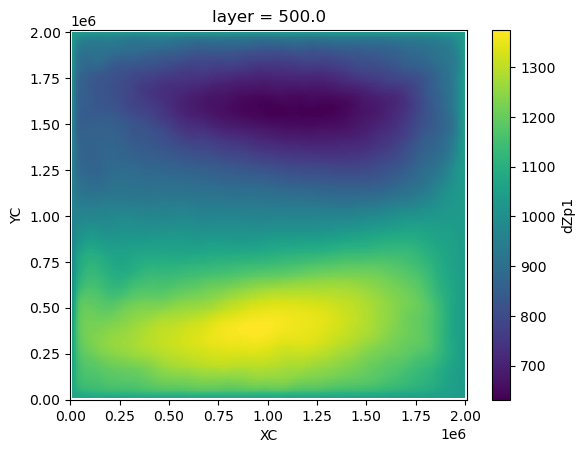

In [19]:
dzp1b.isel(layer=0).plot()